In [1]:
import pandas as pd
import numpy
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
#%matplotlib inline
#plt.rcParams['figure.figsize'] = (16, 9)
#plt.style.use('ggplot')
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import scipy
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from collections import Counter
import joblib
from scipy.integrate import simps
from datetime import datetime
import sklearn.metrics as metrics
from xgboost import XGBClassifier

def norm_minimax(datos_train, datos_test=None, splits=True, mini=None, maxi=None):
    if (mini is None) and (maxi is None):
        maxi=(np.max(datos_train))
        mini=(np.min(datos_train))
        datos_train = (datos_train-mini)/(maxi-mini)
        return datos_train, mini, maxi
    if (mini is not None) & (maxi is not None) & (splits==True):
        datos_train = (datos_train-mini)/(maxi-mini)
        datos_test = (datos_test-mini)/(maxi-mini)
        return datos_train, datos_test
    if (mini is not None) & (maxi is not None) & (splits==False):
        datos_train = (datos_train-mini)/(maxi-mini)
        return datos_train
    print('Error de entradas en nomalizacion minimax')
    return -1

# calcular peso de clase para darselo al modelo
def pesos_clases(y_train, only_pos=False):
    cant_refa = 0
    cant_norefa = 0
    for i in range(0, len(y_train)):
        if y_train[i] == 1:
            cant_refa = cant_refa + 1
        else:
            cant_norefa = cant_norefa + 1
    total = cant_norefa + cant_refa
    porcentaje_refa = (cant_refa/total)*100
    print('Porcentaje de refacturas: %0.2f' % porcentaje_refa)
    weight_for_0 = (1 / cant_norefa)*(total)/2.0 
    weight_for_1 = ((1 / cant_refa)*(total)/2.0) #/2 #dividido 2 para que no haya tantos falsos positivos
    class_weight = {0: weight_for_0, 1: weight_for_1}
    initial_bias = np.log([cant_refa/cant_norefa])
    #weight = cant_norefa/cant_refa
    print('Peso de clase "0" (sin refactura): {:.2f}'.format(weight_for_0))
    print('Peso de clase "1" (con refactura): {:.2f}'.format(weight_for_1))
    print('Bias inicial: ',initial_bias)
    if only_pos==False:
        return weight_for_0, weight_for_1, initial_bias
    else:
        return weight_for_1

def curva_ROC(fpr, tpr, roc_auc):  
    # method I: plt
    plt.figure(figsize=(5, 5))
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc, color='DarkSeaGreen')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'--', color='RoyalBlue')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend()
    #plt.savefig("ROC" + str(w) + '-' + T + ".jpg")
    plt.show()

#definimos funciona para mostrar los resultados
def mostrar_resultados(y_test, pred_y, umbral=None):
    for i in range(0, len(pred_y)):
        if pred_y[i] > umbral:
            pred_y[i] = 1
        else:
            pred_y[i] = 0
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(5, 5))
    sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", cmap='Blues');
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    #plt.savefig("matriz_confusion" + str(w) + '-' + T + ".jpg")
    plt.show()
    #print (classification_report(y_test, pred_y))
    
def MOSTRAR_METRICAS(y_test, pred_y, umbral=None, beta=None):
    for i in range(0, len(pred_y)):
        if pred_y[i] > umbral:
            pred_y[i] = 1
        else:
            pred_y[i] = 0
    [TN, FP],[FN,TP] = confusion_matrix(y_test, pred_y)
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    f1_score = (2*recall*precision) / (recall + precision)
    g_mean = np.sqrt((TP / (TP + FN)) * (TN / (TN + FP)))
    print('Recall: %0.4f' % recall)
    print('Precision: %0.4f' % precision)
    print('F1-score: %0.4f' % f1_score)
    print('G-mean: %0.4f' % g_mean)
    if beta is not None:
        f_beta = (((1 + beta)**2) * recall * precision) / (((beta**2) * precision) + recall)
        print('F-measure: %0.4f' % f_beta)
        return recall, precision, f1_score, g_mean, f_beta
    return recall, precision, f1_score, g_mean
        
def AUCM_PLOT(archivo):
    # Calculo de porcentajes
    porc_TD = numpy.arange(0, 1.01, 0.01)
    porc_TR = numpy.arange(0, 1.01, 0.01)
    j = 0
    maximo = 0
    limite_pasado = False
    for umbral in numpy.arange(0, 1.01, 0.01):
        predprob_y = joblib.load(archivo)
        for i in range(0, len(predprob_y)):
            if predprob_y[i] > umbral:
                predprob_y[i] = 1
            else:
                predprob_y[i] = 0
        [TN, FP],[FN,TP] = confusion_matrix(y_test, predprob_y)
        porc_TD[j] = (TP + FP) / (TP + FP + TN + FN)
        porc_TR[j] = TP / (TP + FN)
        if maximo < (porc_TR[j] - porc_TD[j]):
            maximo = umbral
            maximo_registros = TP + FP
        if ((TP+FP) < 3500) & (limite_pasado==False):
            limite_umbral = umbral
            limite_refactura = porc_TR[j]
            revisar = TP + FP
            limite_pasado = True
        j+=1
        #print('interacion de: ', umbral)
    umbral = numpy.arange(0, 1.01, 0.01)
    # Calculo de areas
    rocm_total = simps(porc_TD, umbral)
    rocm_refa = simps(porc_TR, umbral)
    AUCM = rocm_refa - rocm_total
    print('AUCM = %0.5f' % AUCM)
    #grafica
    plt.figure(figsize=(5, 5))
    plt.title('Receiver Operating Characteristic Modified (ROCM)')
    plt.plot(umbral, porc_TD, 'b', label = 'AUC Total = %0.4f' % rocm_total, color='indianred')
    plt.legend(loc = 'lower right')
    plt.plot(umbral, porc_TR, 'b', label = 'AUC Refacturas = %0.4f' % rocm_refa, color='DarkSeaGreen')
    plt.legend(loc = 'lower right')
    plt.xlim([1.01, -0.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('% del Total')
    plt.xlabel('% probabilidad de refactura desde')
    plt.legend()
    #plt.savefig("ROCM" + str(w) + '-' + T + ".jpg")
    plt.show()
    return limite_umbral, limite_refactura, revisar, maximo, maximo_registros, AUCM

def Carga_Datos(archivo=None, limpia=False):
    if limpia==True:
        if len(archivo)>1:
            dtype = {'NRO_SUMINISTRO': 'str', 'COD_DIAMETRO': 'str', 'LECTURA_TERRENO': 'float32', 'CLAVE_TERRENO': 'str',
                     'LECTURA_ANT': 'float32', 'CONSUMO_BASE': 'float32', 'CONSUMO_PROM': 'float32', 'CATEGORIA': 'str',
                     'TIP_DOCUMENTO': 'str', 'COD_LECTOR': 'str', 'COD_OBS': 'str', 'COD_LOCALIDAD': 'str', 'RECORR1': 'str',
                     'RECORR2': 'str', 'TIE_REMAR': 'str', 'ID_RELACION': 'str', 'COD_EMPRESA': 'str', 
                     'CLAVE_TERRENO_MES_ANT': 'str', 'CONS_BASE_MES_ANT': 'float32', 'COD_OBS_MES_ANT': 'str',
                     'CLAVE_TERRENO_MISMO_MES_ANNO_ANT': 'str', 'CONS_BASE_MISMO_MES_ANNO_ANT': 'float32',
                     'COD_OBS_MISMO_MES_ANNO_ANT': 'str', 'ANNO': 'str', 'MES': 'str', 'ANALISTA': 'float32', 
                     'TIENE_REFA': 'float32'}
            data1 = pd.read_csv(archivo[0], delimiter=';', dtype=dtype, low_memory=False)
            data2 = pd.read_csv(archivo[1], delimiter=';', dtype=dtype, low_memory=False)
            Data = pd.concat([data1, data2], ignore_index=True)
            del data1
            del data2
            Data = Data.drop('Unnamed: 0', axis=1)
        else:
            dtype = {'NRO_SUMINISTRO': 'str', 'COD_DIAMETRO': 'str', 'LECTURA': 'float32', 'LECTURA_TERRENO': 'float32',
                     'CLAVE_TERRENO': 'str', 'LECTURA_ANT': 'float32', 'CONSUMO_BASE': 'float32', 'CONSUMO_PROM': 'float32',
                     'CATEGORIA': 'str', 'TIP_DOCUMENTO': 'str', 'COD_LECTOR': 'str', 'COD_OBS': 'str', 'COD_LOCALIDAD': 'str',
                     'RECORR1': 'str', 'RECORR2': 'str', 'TIE_REMAR': 'str', 'ID_RELACION': 'str', 'COD_EMPRESA': 'str',
                     'CLAVE_LECTURA': 'str', 'CLAVE_TERRENO_MES_ANT': 'str', 'CONS_BASE_MES_ANT': 'float32', 'COD_OBS_MES_ANT': 'str',
                     'CLAVE_TERRENO_MISMO_MES_ANNO_ANT': 'str', 'CONS_BASE_MISMO_MES_ANNO_ANT': 'float32',
                     'COD_OBS_MISMO_MES_ANNO_ANT': 'str', 'ANNO': 'str', 'MES': 'str', 'ANALISTA': 'float32', 'TIENE_REFA': 'float32'}
            Data = pd.read_csv(archivo[0], delimiter=';', dtype=dtype, low_memory=False)
            Data = Data.drop('Unnamed: 0', axis=1)
        print('Se Cargo base de datos')
        return Data
    #Se agrega el tipo de variable de cada colunma para visualización
    dtype = {'NRO_SUMINISTRO': 'str', 'COD_DIAMETRO': 'str', 'LECTURA': 'float32', 'LECTURA_TERRENO': 'float32',
             'CLAVE_TERRENO': 'str', 'LECTURA_ANT': 'float32', 'CONSUMO_BASE': 'float32', 'CONSUMO_PROM': 'float32',
             'CATEGORIA': 'str', 'TIP_DOCUMENTO': 'str', 'COD_LECTOR': 'str', 'COD_OBS': 'str', 'COD_LOCALIDAD': 'str',
             'RECORR1': 'str', 'RECORR2': 'str', 'TIE_REMAR': 'str', 'ID_RELACION': 'str', 'COD_EMPRESA': 'str',
             'CLAVE_LECTURA': 'str', 'CLAVE_TERRENO_MES_ANT': 'str', 'CONS_BASE_MES_ANT': 'float32', 'COD_OBS_MES_ANT': 'str',
             'CLAVE_TERRENO_MISMO_MES_ANNO_ANT': 'str', 'CONS_BASE_MISMO_MES_ANNO_ANT': 'float32', 
             'COD_OBS_MISMO_MES_ANNO_ANT': 'str', 'ANNO': 'str', 'MES': 'str', 'TIENE_REFA': 'float32'}
    #se leen los datos
    data1 = pd.read_csv(archivo[0], delimiter=';', dtype=dtype, low_memory=False)
    data2 = pd.read_csv(archivo[1], delimiter=';', dtype=dtype, low_memory=False)
    #se encadenan todos los chunks en una tabla
    Data = pd.concat([data1, data2], ignore_index=True)
    del data1
    del data2
    data3 = pd.read_csv(archivo[2], delimiter=';', dtype=dtype, low_memory=False)
    Data = pd.concat([Data, data3], ignore_index=True)
    del data3
    Data = Data.drop([len(Data)-1],axis=0)
    #Reemplazo de nulos -------------------------------------------------------------------------------------------------------
    Data['COD_DIAMETRO']=Data['COD_DIAMETRO'].fillna('13')
    Data['CATEGORIA']=Data['CATEGORIA'].fillna('R')
    Data['COD_LECTOR']=Data['COD_LECTOR'].fillna('0')
    Data['TIE_REMAR']=Data['TIE_REMAR'].fillna('N')
    Data['COD_OBS']=Data['COD_OBS'].fillna('ACE')
    Data['COD_OBS_MES_ANT']=Data['COD_OBS_MES_ANT'].fillna('ACE')
    Data['COD_OBS_MISMO_MES_ANNO_ANT']=Data['COD_OBS_MISMO_MES_ANNO_ANT'].fillna('ACE')
    Data['CLAVE_TERRENO_MES_ANT']=Data['CLAVE_TERRENO_MES_ANT'].fillna('N')
    Data['CLAVE_TERRENO_MISMO_MES_ANNO_ANT']=Data['CLAVE_TERRENO_MISMO_MES_ANNO_ANT'].fillna('N')
    Data['CONSUMO_BASE']=Data['CONSUMO_BASE'].fillna(0)
    Data['CONS_BASE_MES_ANT']=Data['CONS_BASE_MES_ANT'].fillna(0)
    #pre-procesamiento de algunas columnas ------------------------------------------------------------------------------------
    Data.CATEGORIA = Data.CATEGORIA.replace({"G": 'R', "1": 'R', "O": 'F'})
    Data.COD_DIAMETRO = Data.COD_DIAMETRO.replace({"13": '013'})
    Data = Data.drop(Data[Data['CATEGORIA']=='F'].index)
    #Filtrado casos atipicos 03-2016 LISTO -------------------------------------------------------------------------------------
    Data = Data.drop(Data[(Data['MES']=='3') & (Data['ANNO']=='2016')].index)
    #Data = Data.drop(Data[((Data['MES']=='3') & (Data['ANNO']=='2016') & (Data['COD_EMPRESA']=='1') & (Data['TIENE_REFA']==1)) &
    #                      ((Data['COD_OBS']=='ACE') | (Data['COD_OBS']=='DXS') | (Data['COD_OBS']=='DHS') | (Data['COD_OBS']=='CXS') | (Data['COD_OBS']=='LAM') | (Data['COD_OBS']=='ASM') | (Data['COD_OBS']=='SUS') | (Data['COD_OBS']=='BYP')) &
    #                      ((Data['CLAVE_TERRENO']=='1') | (Data['CLAVE_TERRENO']=='L') | (Data['CLAVE_TERRENO']=='N') | (Data['CLAVE_TERRENO']=='R'))
    #                     ].index)
    #Filtrado casos atipicos 10-2016 LISTO
    Data = Data.drop(Data[(Data['MES']=='10') & (Data['ANNO']=='2016')].index)
    #Data = Data.drop(Data[((Data['MES']=='10') & (Data['ANNO']=='2016') & (Data['COD_EMPRESA']=='2') & (Data['TIENE_REFA']==1)) &
    #                      ((Data['COD_OBS']=='ACE') | (Data['COD_OBS']=='CVE')) &
    #                      (Data['CLAVE_TERRENO']=='N')].index)
    #Filtrado casos atipicos 05-2017 LISTO
    Data = Data.drop(Data[(Data['MES']=='5') & (Data['ANNO']=='2017')].index)
    #Data = Data.drop(Data[((Data['MES']=='5') & (Data['ANNO']=='2017') & (Data['COD_EMPRESA']=='2') & (Data['TIENE_REFA']==1)) &
    #                      ((Data['RECORR1']=='08')|(Data['RECORR1']=='07')|(Data['RECORR1']=='06')|(Data['RECORR1']=='05')|
    #                       (Data['RECORR1']=='04')|(Data['RECORR1']=='03')|(Data['RECORR1']=='02')|(Data['RECORR1']=='01')) &
    #                      ((Data['COD_OBS']=='ACE') | (Data['COD_OBS']=='CC') | (Data['COD_OBS']=='DHS') | (Data['COD_OBS']=='CVE') | (Data['COD_OBS']=='LAM') | (Data['COD_OBS']=='ASM') | (Data['COD_OBS']=='SUS') | (Data['COD_OBS']=='CVA')) &
    #                      ((Data['CLAVE_TERRENO']=='N') | (Data['CLAVE_TERRENO']=='2') | (Data['CLAVE_TERRENO']=='1') | (Data['CLAVE_TERRENO']=='8') | (Data['CLAVE_TERRENO']=='I') | (Data['CLAVE_TERRENO']=='L') | (Data['CLAVE_TERRENO']=='P'))].index)
    #Filtrado casos atipicos 06-2017
    Data = Data.drop(Data[(Data['MES']=='6') & (Data['ANNO']=='2017')].index)
    #Data = Data.drop(Data[((Data['MES']=='6') & (Data['ANNO']=='2017') & (Data['COD_EMPRESA']=='2') & (Data['TIENE_REFA']==1)) &
    #                      ((Data['RECORR1']=='09')|(Data['RECORR1']=='10')|(Data['RECORR1']=='11')|(Data['RECORR1']=='12')|
    #                       (Data['RECORR1']=='13')|(Data['RECORR1']=='14')|(Data['RECORR1']=='15')|(Data['RECORR1']=='16')|
    #                       (Data['RECORR1']=='17')|(Data['RECORR1']=='18')|(Data['RECORR1']=='19')|(Data['RECORR1']=='20')) &
    #                      ((Data['COD_OBS']=='ACE') | (Data['COD_OBS']=='CC') | (Data['COD_OBS']=='DHS') | (Data['COD_OBS']=='CVE') | (Data['COD_OBS']=='LAM') | (Data['COD_OBS']=='ASM') | (Data['COD_OBS']=='SUS') | (Data['COD_OBS']=='DPU') | (Data['COD_OBS']=='LDE')) &
    #                      ((Data['CLAVE_TERRENO']=='N') | (Data['CLAVE_TERRENO']=='2') | (Data['CLAVE_TERRENO']=='1') | (Data['CLAVE_TERRENO']=='8') | (Data['CLAVE_TERRENO']=='3') | (Data['CLAVE_TERRENO']=='I') | (Data['CLAVE_TERRENO']=='L') | (Data['CLAVE_TERRENO']=='P') | (Data['CLAVE_TERRENO']=='T'))].index)
    #Filtrado casos atipicos 06-2018 LISTO
    Data = Data.drop(Data[(Data['MES']=='6') & (Data['ANNO']=='2018')].index)
    #Data = Data.drop(Data[((Data['MES']=='6') & (Data['ANNO']=='2018') & (Data['COD_EMPRESA']=='1') & (Data['TIENE_REFA']==1)) &
    #                      (Data['COD_OBS']=='CC') &
    #                      ((Data['CLAVE_TERRENO']=='1') | (Data['CLAVE_TERRENO']=='2'))].index)
    #Reordenar los indices de dataframe
    Data = Data.reset_index(drop=True)
    #Agregar columna de responsabilidad del analista --------------------------------------------------------------------------
    Data.insert(len(Data.columns)-1, 'ANALISTA', 0)
    #codigos de responsabilidad del analista
    Data.loc[Data['CLAVE_LECTURA'] == 'P', 'ANALISTA'] = 1
    Data.loc[Data['CLAVE_LECTURA'] == 'A', 'ANALISTA'] = 1
    Data.loc[Data['CLAVE_LECTURA'] == 'B', 'ANALISTA'] = 1
    Data.loc[Data['CLAVE_LECTURA'] == 'C', 'ANALISTA'] = 1
    Data.loc[Data['CLAVE_LECTURA'] == 'G', 'ANALISTA'] = 1
    Data.loc[Data['CLAVE_LECTURA'] == 'M', 'ANALISTA'] = 1
    Data.loc[Data['CLAVE_LECTURA'] == 'O', 'ANALISTA'] = 1
    Data.loc[Data['CLAVE_LECTURA'] == 'W', 'ANALISTA'] = 1
    Data.loc[Data['CLAVE_LECTURA'] == 'Z', 'ANALISTA'] = 1
    
    print('Se Cargo base de datos')
    return Data

#def Preprocesamiento_Datos(Data, codigo_empresa=None, anno=None, ohe=None, mini=None, maxi=None, le=None):
def Preprocesamiento_Datos(Data, splits=True, ohe=None, mini=None, maxi=None, SS=None, SS_num=None, le=None):
    if (ohe is None) and (mini is None) and (maxi is None) and (SS is None) and (SS_num is None) and (le is None):
    #if (ohe is None) and (mini is None) and (maxi is None) and (le is None):
        codificacion=True
    else:
        codificacion=False
    
    #eliminacion de algunas columnas que no sirven
    Data = Data.drop('NRO_SUMINISTRO', axis=1)
    Data = Data.drop('COD_LECTOR', axis=1)
    Data = Data.drop('ANNO', axis=1)
    
    #guardar columnas que sean float
    columnas = Data.columns
    col = np.zeros(len(Data.columns))
    j = 0
    for i in columnas:
        if Data[i].dtype == 'f':
            col[j] = 1
        j = j + 1
            
    Dataset = Data.values
    del Data
            
    x_train = Dataset[:, :-1]
    y_train = Dataset[:,-1]
    del Dataset
    x_train = x_train.astype(str)
    y_train = y_train.reshape((len (y_train), 1))

    #Splits
    if (codificacion==False) & (splits==True):
        x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3,train_size=0.7)
        print('Splits listos')
    ######################################################################################################################
    #Preparar datos para codificacion
    x_train = np.transpose(x_train)
    if (codificacion==False) & (splits==True):
        x_test = np.transpose(x_test)
            
    #Separar datos numericos de categoricos
    init = 0
    k = 0
    for i in range(0, len(col)-1):
        if col[i] == 1:
            if init == 2:
                x_train_num = np.append(x_train_num, [x_train[k]], axis=0)
                x_train = np.delete(x_train, k, axis=0)
                if (codificacion==False) & (splits==True):
                    x_test_num = np.append(x_test_num, [x_test[k]], axis=0)
                    x_test = np.delete(x_test, k, axis=0)
                k = k - 1
            if init == 1:
                x_train_num = np.append([x_train_num], [x_train[k]], axis=0)
                x_train = np.delete(x_train, k, axis=0)
                if (codificacion==False) & (splits==True):
                    x_test_num = np.append([x_test_num], [x_test[k]], axis=0)
                    x_test = np.delete(x_test, k, axis=0)
                k = k - 1
                init = 2
            if init == 0:
                x_train_num = x_train[k]
                x_train = np.delete(x_train, k, axis=0)
                if (codificacion==False) & (splits==True):
                    x_test_num = x_test[k]
                    x_test = np.delete(x_test, k, axis=0)
                k = k - 1
                init = 1
            k = k + 1
        else:
            k = k + 1
    
    #codificacion OneHot para datos categorios ---------------------------------------------------------------------------
    x_train = np.transpose(x_train)
    if (codificacion==False) & (splits==True):
        x_test = np.transpose(x_test)
    
    if ohe is None:
        ohe = OneHotEncoder(dtype='float16',handle_unknown='ignore')
        ohe.fit(x_train)
    
    x_train = ohe.transform(x_train)
    if (codificacion==False) & (splits==True):
        x_test = ohe.transform(x_test)
    
    #StandarScaler, podria ocuparse, pero pensandolos bien no tiene mucho sentido 
    if SS is None:
        SS = StandardScaler(with_mean=False)
        SS.fit(x_train) 
    x_train = SS.transform(x_train)
    if (codificacion==False) & (splits==True):
        x_test = SS.transform(x_test)
    
    x_train = np.transpose(x_train)
    if (codificacion==False) & (splits==True):
        x_test = np.transpose(x_test)
            
    #estandarizacion minimax para datos numericos ----------------------------------------------------------------------
    x_train_num = x_train_num.astype('float')
    if (codificacion==False) & (splits==True):
        x_test_num = x_test_num.astype('float')
    
    if (mini is None) & (maxi is None):
        mini = np.zeros(len(x_train_num))
        maxi = np.zeros(len(x_train_num))
        for i in range(0, len(x_train_num)):
            x_train_num[:,i], mini[i], maxi[i] = norm_minimax(datos_train=x_train_num[:,i], splits=False)
    if (mini is not None) & (maxi is not None) & (splits==True):
        for i in range(0, len(x_train_num)):
            x_train_num[:,i], x_test_num[:,i] = norm_minimax(datos_train=x_train_num[:,i], datos_test=x_test_num[:,i],
                                                            mini=mini[i], maxi=maxi[i])
    if (mini is not None) & (maxi is not None) & (splits==False):
        for i in range(0, len(x_train_num)):
            x_train_num[:,i] = norm_minimax(datos_train=x_train_num[:,i], splits=False, mini=mini[i], maxi=maxi[i])
    
    
    #StandarScaler, podria ocuparse, pero pensandolos bien no tiene mucho sentido    
    x_train_num = np.transpose(x_train_num)
    if (codificacion==False) & (splits==True):
        x_test_num = np.transpose(x_test_num)
    if SS_num is None:
        SS_num = StandardScaler()
        SS_num.fit(x_train_num)
    x_train_num = SS_num.fit_transform(x_train_num)
    if (codificacion==False) & (splits==True):
        x_test_num = SS_num.transform(x_test_num)
    x_train_num = np.transpose(x_train_num)
    if (codificacion==False) & (splits==True):
        x_test_num = np.transpose(x_test_num)
    
    #volver a unir los datos -------------------------------------------------------------------------------------------
    x_train = scipy.sparse.vstack((x_train, x_train_num))
    del x_train_num
    if (codificacion==False) & (splits==True):
        x_test = scipy.sparse.vstack((x_test, x_test_num))
        del x_test_num
    
    x_train = np.transpose(x_train)
    if (codificacion==False) & (splits==True):
        x_test = np.transpose(x_test)
    
    #codificar las etiquetas ---------------------------------------------------------------------------------------------
    if le is None:
        le = LabelEncoder()
        le.fit(y_train)
     
    y_train = le.transform(y_train)
    if (codificacion==False) & (splits==True):
        y_test = le.transform(y_test)
    
    print('Codificacion lista')
    print('Dimensiones datos: ',x_train.shape)
    print('Dimensiones etiquetas: ',y_train.shape)
    
    if (codificacion==False) & (splits==True):
        return x_train, x_test, y_train, y_test
    
    if (codificacion==False) & (splits==False):
        return x_train, y_train
    
    if codificacion==True:
        #Guardar tranformaciones de datos
        joblib.dump(ohe, 'ohe.pkl')
        joblib.dump(mini, 'mini.pkl')
        joblib.dump(maxi, 'maxi.pkl')
        joblib.dump(SS, 'SS.pkl')
        joblib.dump(SS_num, 'SS_num.pkl')
        joblib.dump(le, 'le.pkl')
        return x_train, y_train, ohe, mini, maxi, SS, SS_num, le
    
    else: 
        print('Error en argumentos de funcion de pre-procesamiento de datos')
        return -1
    #----------------------------------------------------------------------------------------------------------------------
    
#metricas ha ocupar
metricas = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
]
print('librerias y funciones listas')

librerias y funciones listas


In [2]:
start_time = datetime.now()
#Carga datos
#archivo = ['Data_analista2016-2018.csv']
#archivo = ['../chunk1_Data_noanalista2016-2018.csv', '../chunk2_Data_noanalista2016-2018.csv']
archivo = ['../chunk1_2016-2018v3.csv', '../chunk2_2016-2018v3.csv', '../chunk3_2016-2018v3.csv']
Data = Carga_Datos(archivo=archivo)

#Eliminacion de columnas que no sirven
Data = Data.drop('CLAVE_LECTURA', axis=1)
Data = Data.drop('LECTURA', axis=1)

#Eliminacion de columnas que no sirven
Data = Data.drop('ANALISTA', axis=1)

#Creacion de data train y test (diciembre 2018)
Data_test1 = Data.drop(Data[(Data['MES']!='12') | (Data['ANNO']!='2018')].index)
#Data_test2 = Data.drop(Data[(Data['MES']!='11') | (Data['ANNO']!='2018')].index)
Data = Data.drop(Data[(Data['MES']=='12') & (Data['ANNO']=='2018')].index)
#Data = Data.drop(Data[(Data['MES']=='11') & (Data['ANNO']=='2018')].index)

print('Division de datos lista')

Se Cargo base de datos
Division de datos lista


In [3]:
#pre-procesamiento de datos y carga de codificaciones
ohe = joblib.load('../ohe.pkl')
mini = joblib.load('../mini.pkl')
maxi = joblib.load('../maxi.pkl')
SS = joblib.load('../SS.pkl')
SS_num = joblib.load('../SS_num.pkl')
le = joblib.load('../le.pkl')
x_train, y_train = Preprocesamiento_Datos(Data, splits=False,
                                          ohe=ohe, mini=mini, maxi=maxi, SS=SS, SS_num=SS_num, le=le)
del Data
#calcular pesos de cada clase para darselo al modelo
weight_for_0, weight_for_1, intial_bias = pesos_clases(y_train) 
class_weight = {0: weight_for_0, 1: weight_for_1} 

from sklearn.linear_model import LogisticRegression
# define model
model_LR = LogisticRegression(solver='lbfgs', C=100, class_weight=class_weight, random_state=2020, n_jobs=-1,
                              verbose=2, max_iter=1000)

# execute LR
print('Se empieza a entrenar modelo')
model_LR.fit(x_train, y_train)
del x_train, y_train, ohe, mini, maxi, SS, SS_num, le
print('Se entreno el modelo')
# save the model to disk
filename = 'modelo_LR_DNA_sindiv.sav'
joblib.dump(model_LR, filename)
print('Time elapsed (hh:mm:ss.ms) {}'.format(datetime.now() - start_time))

/opt/miniconda3/envs/jupyterhub/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Codificacion lista
Dimensiones datos:  (25133729, 994)
Dimensiones etiquetas:  (25133729,)
Porcentaje de refacturas: 1.46
Peso de clase "0" (sin refactura): 0.51
Peso de clase "1" (con refactura): 34.31
Bias inicial:  [-4.21380158]
Se empieza a entrenar modelo


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.


se termina de entrenar modelo
Time elapsed (hh:mm:ss.ms) 1:12:11.880987
Se entreno el modelo
Time elapsed (hh:mm:ss.ms) 1:12:11.932523


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 58.6min finished


In [4]:
# load the model from disk
#model_XGB = joblib.load('model_XGB_V2.sav')

### Resultados DIC18

Sector de facturacion 01


/opt/miniconda3/envs/jupyterhub/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Codificacion lista
Dimensiones datos:  (41946, 994)
Dimensiones etiquetas:  (41946,)


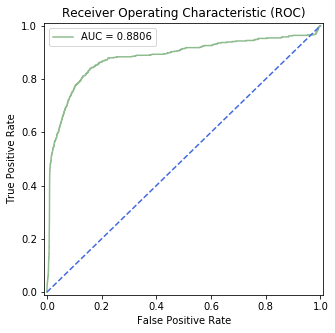

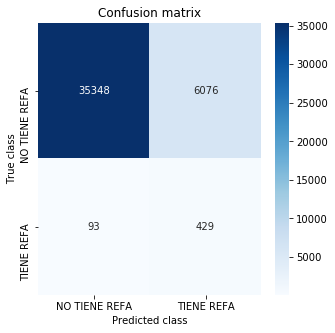

Recall: 0.8218
Precision: 0.0659
F1-score: 0.1221
G-mean: 0.8374
F-measure: 0.8706
AUCM = 0.45023


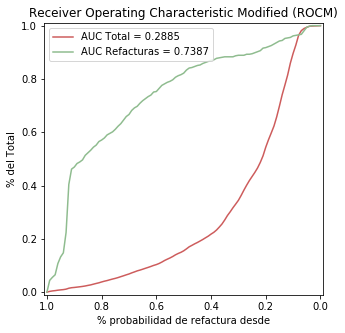

Porcentaje de Refacturas revisadas en limite de analista (3500) es 70.88% con un total de 3468 registros a revisar con el umbral de desicion 66.00
El umbral optimo de revision es 0.64% con un total de 3754 registros a revisar.

Sector de facturacion 02


/opt/miniconda3/envs/jupyterhub/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Codificacion lista
Dimensiones datos:  (55668, 994)
Dimensiones etiquetas:  (55668,)


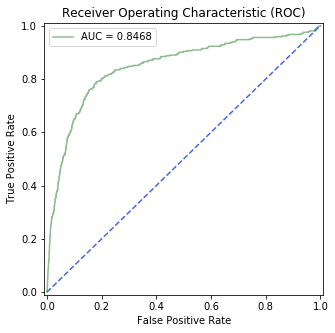

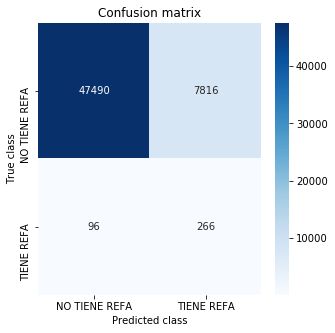

Recall: 0.7348
Precision: 0.0329
F1-score: 0.0630
G-mean: 0.7943
F-measure: 0.6895
AUCM = 0.38032


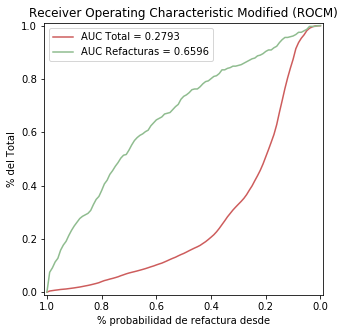

Porcentaje de Refacturas revisadas en limite de analista (3500) es 50.28% con un total de 3428 registros a revisar con el umbral de desicion 73.00
El umbral optimo de revision es 0.56% con un total de 6559 registros a revisar.

Sector de facturacion 03


/opt/miniconda3/envs/jupyterhub/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Codificacion lista
Dimensiones datos:  (37905, 994)
Dimensiones etiquetas:  (37905,)


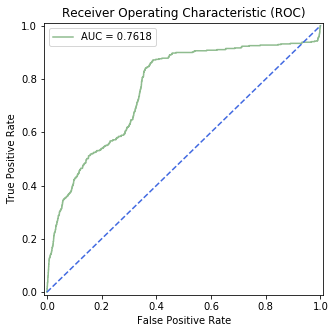

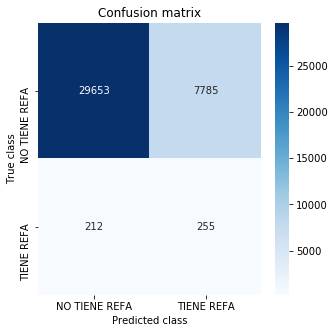

Recall: 0.5460
Precision: 0.0317
F1-score: 0.0600
G-mean: 0.6576
F-measure: 0.5446
AUCM = 0.25376


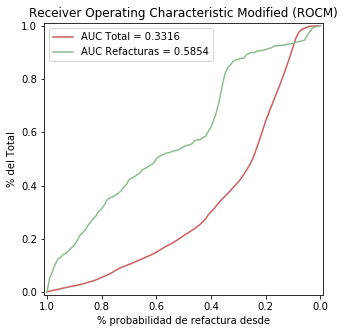

Porcentaje de Refacturas revisadas en limite de analista (3500) es 37.90% con un total de 3481 registros a revisar con el umbral de desicion 73.00
El umbral optimo de revision es 0.37% con un total de 12773 registros a revisar.

Sector de facturacion 04


/opt/miniconda3/envs/jupyterhub/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Codificacion lista
Dimensiones datos:  (46181, 994)
Dimensiones etiquetas:  (46181,)


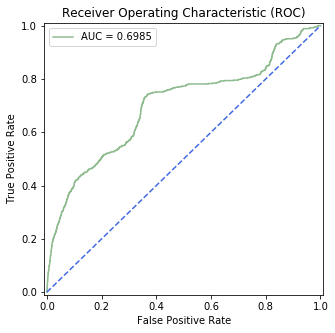

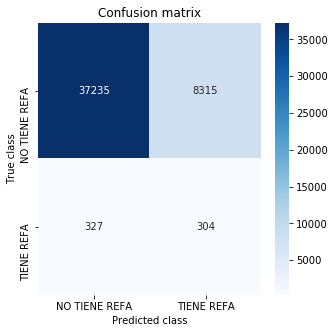

Recall: 0.4818
Precision: 0.0353
F1-score: 0.0657
G-mean: 0.6276
F-measure: 0.5025
AUCM = 0.21025


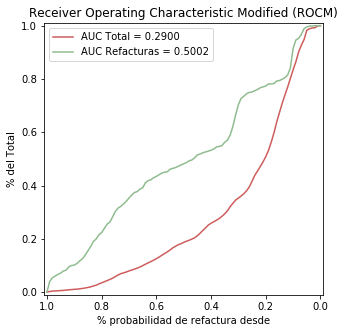

Porcentaje de Refacturas revisadas en limite de analista (3500) es 34.07% con un total de 3487 registros a revisar con el umbral de desicion 71.00
El umbral optimo de revision es 0.31% con un total de 15960 registros a revisar.

Sector de facturacion 05


/opt/miniconda3/envs/jupyterhub/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Codificacion lista
Dimensiones datos:  (49712, 994)
Dimensiones etiquetas:  (49712,)


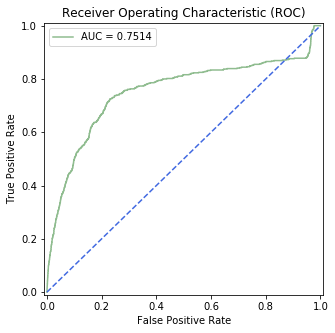

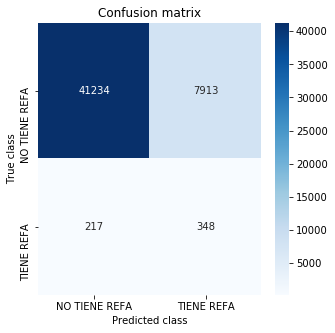

Recall: 0.6159
Precision: 0.0421
F1-score: 0.0789
G-mean: 0.7189
F-measure: 0.6346
AUCM = 0.27869


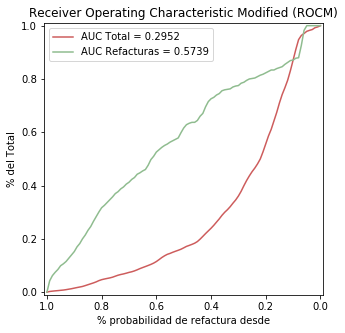

Porcentaje de Refacturas revisadas en limite de analista (3500) es 39.47% con un total de 3399 registros a revisar con el umbral de desicion 72.00
El umbral optimo de revision es 0.46% con un total de 9127 registros a revisar.

Sector de facturacion 06


/opt/miniconda3/envs/jupyterhub/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Codificacion lista
Dimensiones datos:  (51914, 994)
Dimensiones etiquetas:  (51914,)


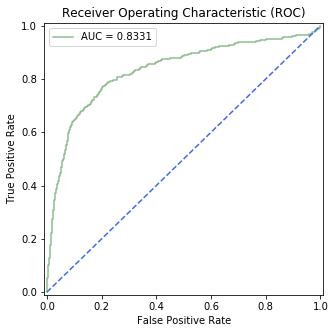

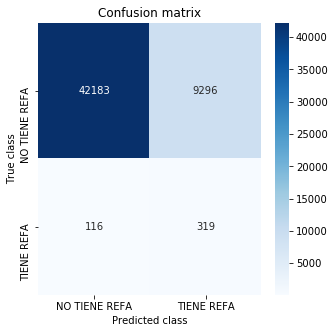

Recall: 0.7333
Precision: 0.0332
F1-score: 0.0635
G-mean: 0.7752
F-measure: 0.6899
AUCM = 0.36251


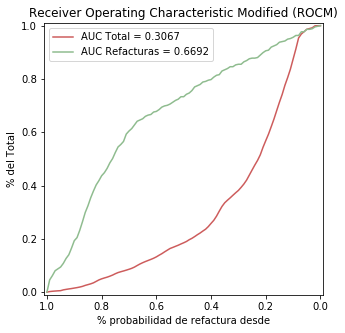

Porcentaje de Refacturas revisadas en limite de analista (3500) es 50.11% con un total de 3323 registros a revisar con el umbral de desicion 76.00
El umbral optimo de revision es 0.55% con un total de 8501 registros a revisar.

Sector de facturacion 07


/opt/miniconda3/envs/jupyterhub/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Codificacion lista
Dimensiones datos:  (54774, 994)
Dimensiones etiquetas:  (54774,)


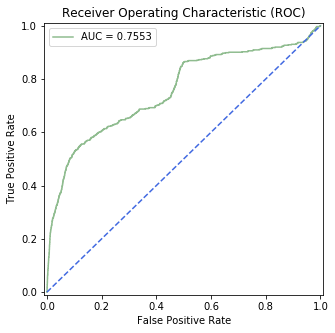

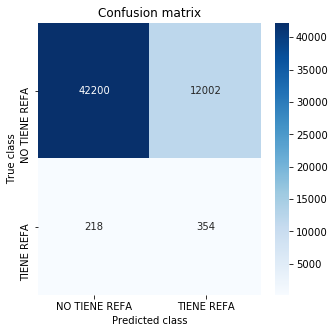

Recall: 0.6189
Precision: 0.0287
F1-score: 0.0548
G-mean: 0.6941
F-measure: 0.5856
AUCM = 0.26754


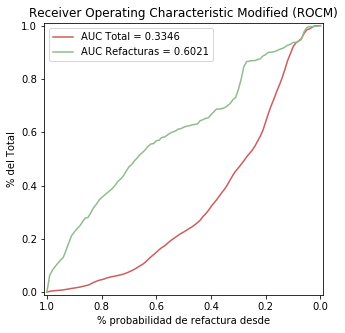

Porcentaje de Refacturas revisadas en limite de analista (3500) es 41.61% con un total de 3427 registros a revisar con el umbral de desicion 74.00
El umbral optimo de revision es 0.62% con un total de 7236 registros a revisar.

Sector de facturacion 08


/opt/miniconda3/envs/jupyterhub/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Codificacion lista
Dimensiones datos:  (39089, 994)
Dimensiones etiquetas:  (39089,)


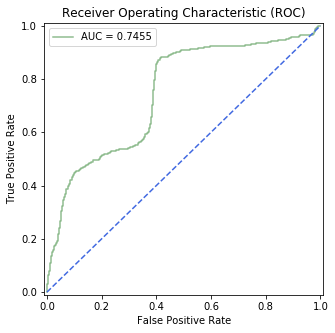

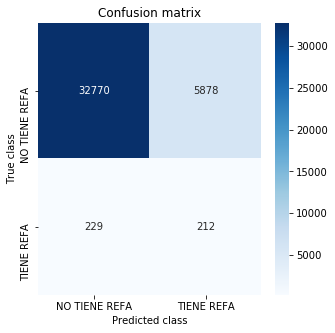

Recall: 0.4807
Precision: 0.0348
F1-score: 0.0649
G-mean: 0.6384
F-measure: 0.5004
AUCM = 0.21833


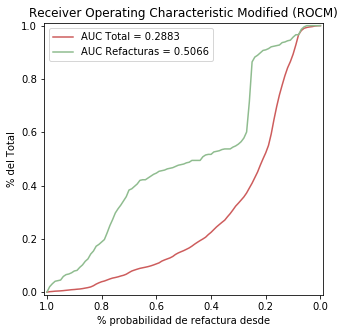

Porcentaje de Refacturas revisadas en limite de analista (3500) es 41.95% con un total de 3489 registros a revisar con el umbral de desicion 66.00
El umbral optimo de revision es 0.35% con un total de 10559 registros a revisar.

Sector de facturacion 09


/opt/miniconda3/envs/jupyterhub/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Codificacion lista
Dimensiones datos:  (40459, 994)
Dimensiones etiquetas:  (40459,)


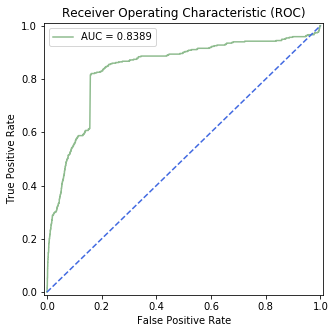

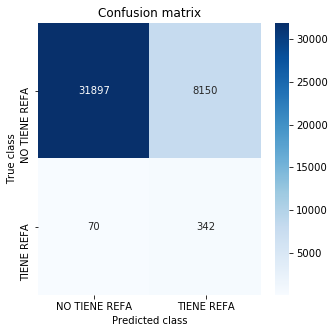

Recall: 0.8301
Precision: 0.0403
F1-score: 0.0768
G-mean: 0.8131
F-measure: 0.7947
AUCM = 0.34737


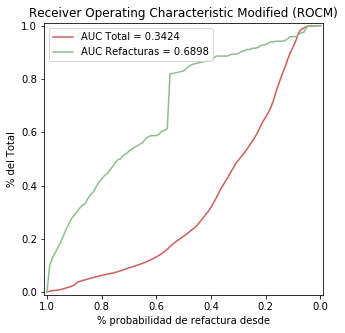

Porcentaje de Refacturas revisadas en limite de analista (3500) es 51.46% con un total de 3388 registros a revisar con el umbral de desicion 72.00
El umbral optimo de revision es 0.55% con un total de 6950 registros a revisar.

Sector de facturacion 10


/opt/miniconda3/envs/jupyterhub/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Codificacion lista
Dimensiones datos:  (45044, 994)
Dimensiones etiquetas:  (45044,)


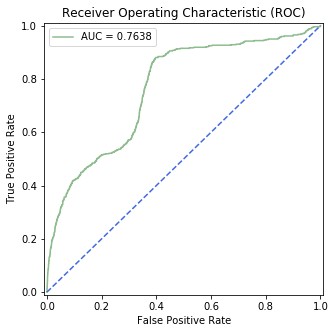

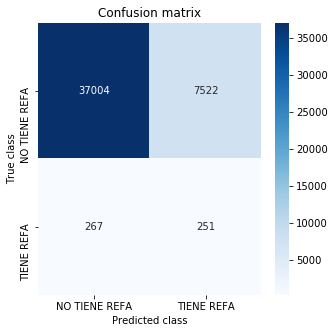

Recall: 0.4846
Precision: 0.0323
F1-score: 0.0605
G-mean: 0.6346
F-measure: 0.4968
AUCM = 0.25086


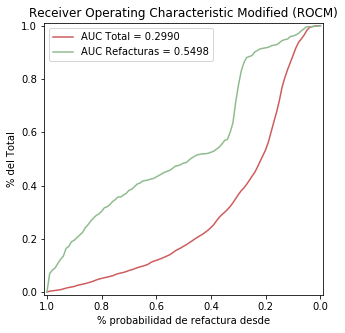

Porcentaje de Refacturas revisadas en limite de analista (3500) es 37.07% con un total de 3479 registros a revisar con el umbral de desicion 71.00
El umbral optimo de revision es 0.46% con un total de 8972 registros a revisar.

Sector de facturacion 11


/opt/miniconda3/envs/jupyterhub/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Codificacion lista
Dimensiones datos:  (51971, 994)
Dimensiones etiquetas:  (51971,)


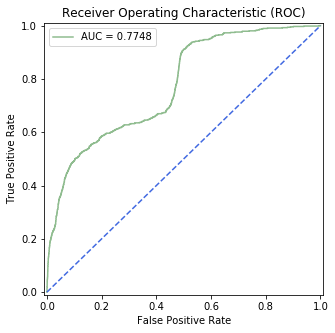

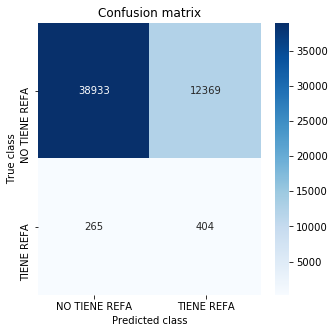

Recall: 0.6039
Precision: 0.0316
F1-score: 0.0601
G-mean: 0.6770
F-measure: 0.5887
AUCM = 0.27155


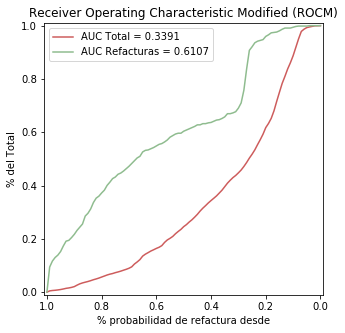

Porcentaje de Refacturas revisadas en limite de analista (3500) es 40.06% con un total de 3341 registros a revisar con el umbral de desicion 78.00
El umbral optimo de revision es 0.58% con un total de 9071 registros a revisar.

Sector de facturacion 12


/opt/miniconda3/envs/jupyterhub/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Codificacion lista
Dimensiones datos:  (40216, 994)
Dimensiones etiquetas:  (40216,)


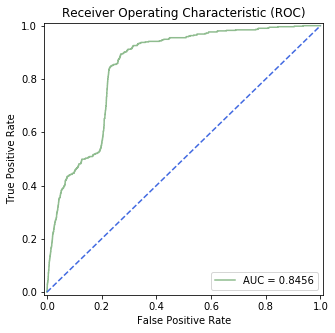

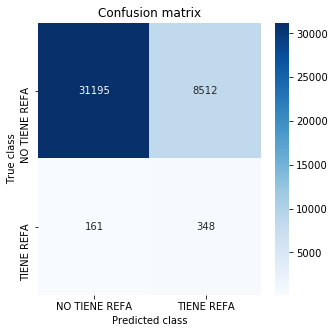

Recall: 0.6837
Precision: 0.0393
F1-score: 0.0743
G-mean: 0.7329
F-measure: 0.6803
AUCM = 0.31785


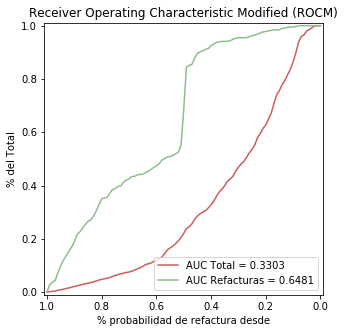

Porcentaje de Refacturas revisadas en limite de analista (3500) es 44.01% con un total de 3498 registros a revisar con el umbral de desicion 67.00
El umbral optimo de revision es 0.49% con un total de 9579 registros a revisar.

Sector de facturacion 13


/opt/miniconda3/envs/jupyterhub/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Codificacion lista
Dimensiones datos:  (39626, 994)
Dimensiones etiquetas:  (39626,)


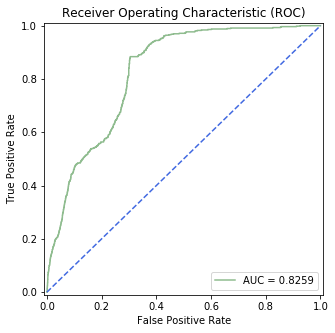

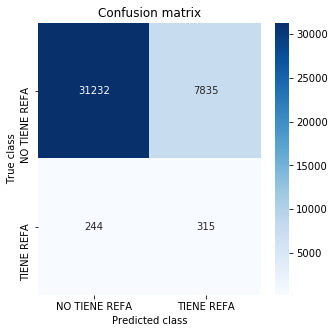

Recall: 0.5635
Precision: 0.0387
F1-score: 0.0723
G-mean: 0.6712
F-measure: 0.5809
AUCM = 0.29101


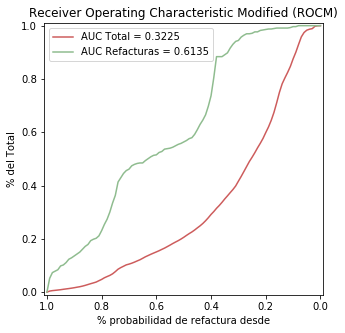

Porcentaje de Refacturas revisadas en limite de analista (3500) es 41.32% con un total de 3411 registros a revisar con el umbral de desicion 74.00
El umbral optimo de revision es 0.41% con un total de 11064 registros a revisar.

Sector de facturacion 14


/opt/miniconda3/envs/jupyterhub/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Codificacion lista
Dimensiones datos:  (40386, 994)
Dimensiones etiquetas:  (40386,)


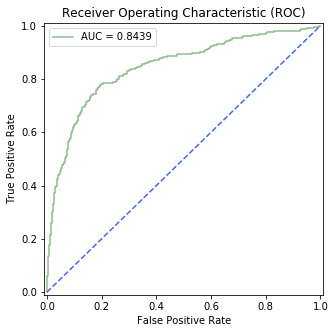

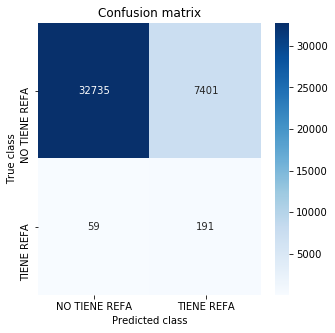

Recall: 0.7640
Precision: 0.0252
F1-score: 0.0487
G-mean: 0.7894
F-measure: 0.6558
AUCM = 0.36651


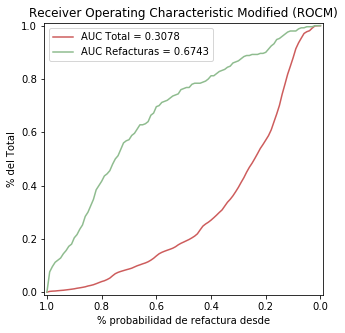

Porcentaje de Refacturas revisadas en limite de analista (3500) es 56.80% con un total de 3390 registros a revisar con el umbral de desicion 71.00
El umbral optimo de revision es 0.57% con un total de 6201 registros a revisar.

Sector de facturacion 15


/opt/miniconda3/envs/jupyterhub/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Codificacion lista
Dimensiones datos:  (44269, 994)
Dimensiones etiquetas:  (44269,)


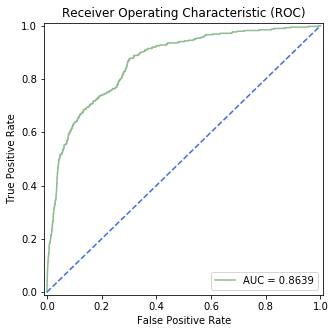

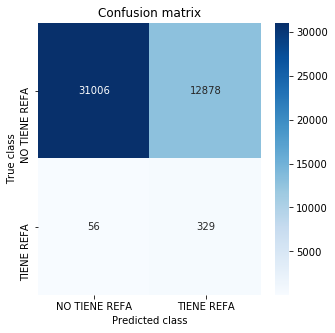

Recall: 0.8545
Precision: 0.0249
F1-score: 0.0484
G-mean: 0.7770
F-measure: 0.7041
AUCM = 0.37577


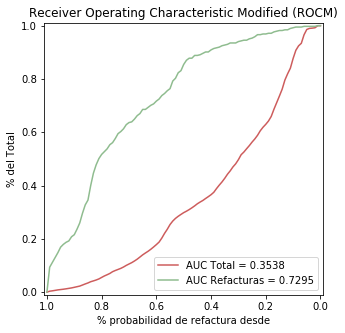

Porcentaje de Refacturas revisadas en limite de analista (3500) es 56.10% con un total de 3397 registros a revisar con el umbral de desicion 76.00
El umbral optimo de revision es 0.58% con un total de 8979 registros a revisar.

Sector de facturacion 16


/opt/miniconda3/envs/jupyterhub/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Codificacion lista
Dimensiones datos:  (42712, 994)
Dimensiones etiquetas:  (42712,)


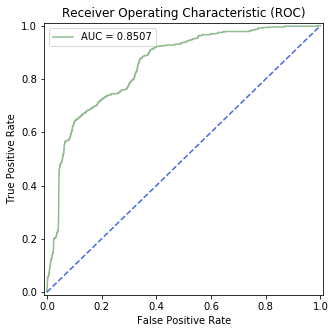

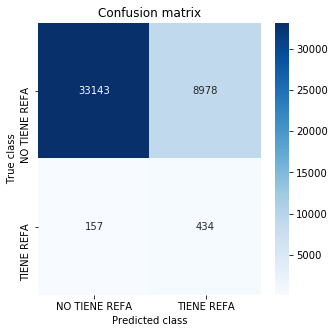

Recall: 0.7343
Precision: 0.0461
F1-score: 0.0868
G-mean: 0.7601
F-measure: 0.7442
AUCM = 0.35136


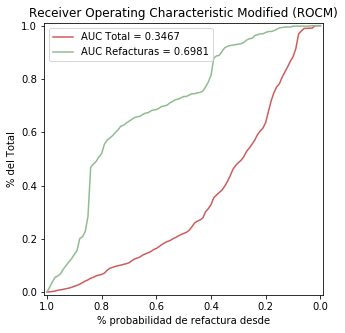

Porcentaje de Refacturas revisadas en limite de analista (3500) es 57.02% con un total de 3494 registros a revisar con el umbral de desicion 78.00
El umbral optimo de revision es 0.60% con un total de 7001 registros a revisar.

Sector de facturacion 17


/opt/miniconda3/envs/jupyterhub/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Codificacion lista
Dimensiones datos:  (35638, 994)
Dimensiones etiquetas:  (35638,)


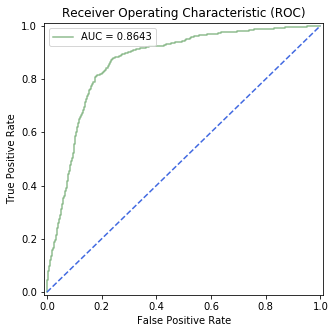

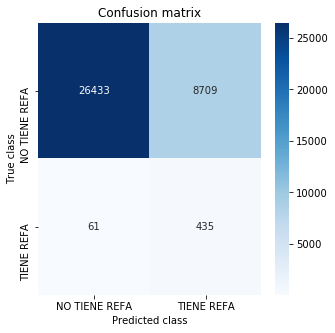

Recall: 0.8770
Precision: 0.0476
F1-score: 0.0902
G-mean: 0.8122
F-measure: 0.8617
AUCM = 0.36093


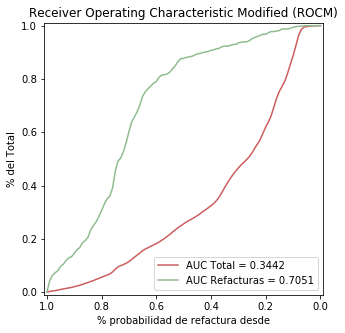

Porcentaje de Refacturas revisadas en limite de analista (3500) es 49.19% con un total de 3375 registros a revisar con el umbral de desicion 74.00
El umbral optimo de revision es 0.61% con un total de 6315 registros a revisar.

Sector de facturacion 18


/opt/miniconda3/envs/jupyterhub/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Codificacion lista
Dimensiones datos:  (38869, 994)
Dimensiones etiquetas:  (38869,)


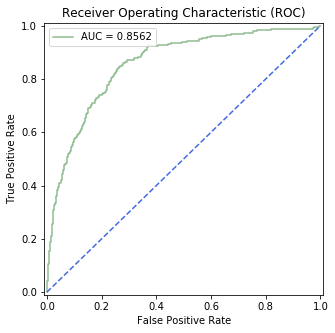

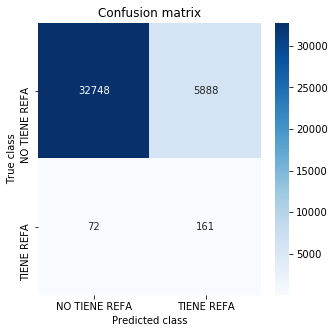

Recall: 0.6910
Precision: 0.0266
F1-score: 0.0513
G-mean: 0.7653
F-measure: 0.6222
AUCM = 0.36265


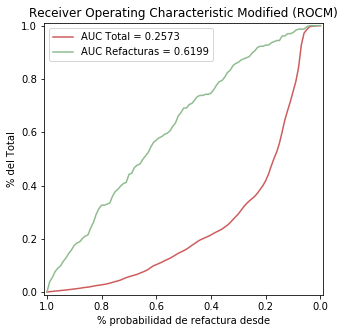

Porcentaje de Refacturas revisadas en limite de analista (3500) es 52.36% con un total de 3302 registros a revisar con el umbral de desicion 63.00
El umbral optimo de revision es 0.52% con un total de 5659 registros a revisar.

Sector de facturacion 19


/opt/miniconda3/envs/jupyterhub/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Codificacion lista
Dimensiones datos:  (34828, 994)
Dimensiones etiquetas:  (34828,)


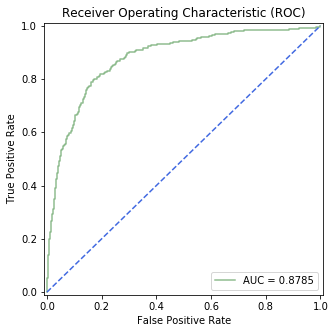

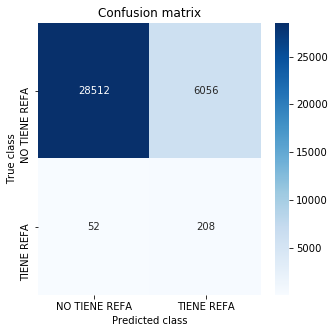

Recall: 0.8000
Precision: 0.0332
F1-score: 0.0638
G-mean: 0.8123
F-measure: 0.7356
AUCM = 0.39919


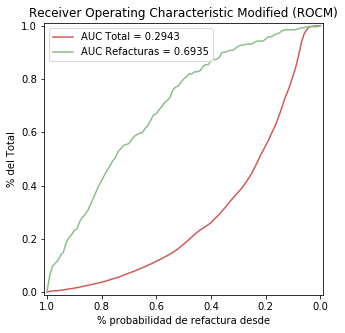

Porcentaje de Refacturas revisadas en limite de analista (3500) es 61.54% con un total de 3367 registros a revisar con el umbral de desicion 64.00
El umbral optimo de revision es 0.58% con un total de 4382 registros a revisar.

Sector de facturacion 20


/opt/miniconda3/envs/jupyterhub/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Codificacion lista
Dimensiones datos:  (37735, 994)
Dimensiones etiquetas:  (37735,)


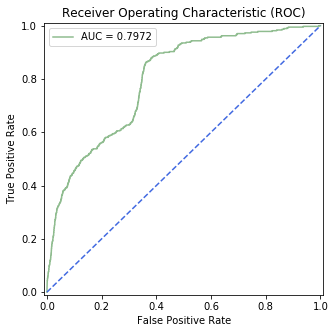

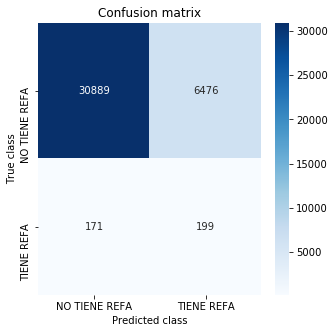

Recall: 0.5378
Precision: 0.0298
F1-score: 0.0565
G-mean: 0.6668
F-measure: 0.5310
AUCM = 0.27161


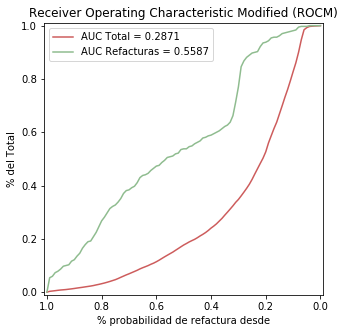

Porcentaje de Refacturas revisadas en limite de analista (3500) es 43.78% con un total de 3455 registros a revisar con el umbral de desicion 65.00
El umbral optimo de revision es 0.41% con un total de 8737 registros a revisar.



In [5]:
start_time = datetime.now()
#crear variables para guardar resultados
recall = np.zeros(20)
precision = np.zeros(20)
f1_score = np.zeros(20)
g_mean = np.zeros(20)
f_beta = np.zeros(20)
AUCM = np.zeros(20)
umbral_limite = np.zeros(20)
refa_5analistas = np.zeros(20)
limite_5analistas = np.zeros(20)
maxima_diff = np.zeros(20)
maxima_diff_reg = np.zeros(20)
sector = np.zeros(20)
for i in range(0,20):
    sector[i] = i+1
#columnas para crear luego el dataframe con los resultados
columns_resultados = ['sector', 'recall', 'precision', 'f1_score', 'g_mean', 'f_beta', 'AUCM', 'umbral_limite', 'refa_5analistas',
                     'limite_5analistas', 'maxima_diff', 'maxima_diff_reg']
#paarametros de algunas metricas
umbral = 0.5
beta = 8
LABELS = ["NO TIENE REFA","TIENE REFA"]

# sectores para iterar
sectores = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']

w = 0
T = 'T1'
for sec in sectores:
    print('Sector de facturacion ' + sec)
    Data_test = Data_test1.drop(Data_test1[Data_test1['RECORR1']!=sec].index)
    
    
    # predicciones
    ohe = joblib.load('../ohe.pkl')
    mini = joblib.load('../mini.pkl')
    maxi = joblib.load('../maxi.pkl')
    SS = joblib.load('../SS.pkl')
    SS_num = joblib.load('../SS_num.pkl')
    le = joblib.load('../le.pkl')
    x_test, y_test = Preprocesamiento_Datos(Data_test, splits=False,
                                            ohe=ohe, mini=mini, maxi=maxi, SS=SS, SS_num=SS_num, le=le)
    
    predprob_y = model_LR.predict_proba(x_test.tocsr())
    joblib.dump(predprob_y[:,1], 'predprob_y_v3-GXB-t1.pkl') #guardo las probabilidades de prediccion

    # grafica ROC
    fpr, tpr, threshold = metrics.roc_curve(y_test, predprob_y[:,1])
    roc_auc = metrics.auc(fpr, tpr)
    curva_ROC(fpr, tpr, roc_auc)
    
    # matriz de confusion y metricas
    predprob_y = joblib.load('predprob_y_v3-GXB-t1.pkl')
    mostrar_resultados(y_test=y_test, pred_y=predprob_y, umbral=umbral)
    recall[w], precision[w], f1_score[w], g_mean[w], f_beta[w] = MOSTRAR_METRICAS(y_test=y_test, pred_y=predprob_y,
                                                                                  umbral=umbral, beta=beta)
    
    # ROCM y datos
    umbral_limite[w], refa_5analistas[w], limite_5analistas[w], maxima_diff[w], maxima_diff_reg[w], AUCM[w] = AUCM_PLOT('predprob_y_v3-GXB-t1.pkl')
    print('Porcentaje de Refacturas revisadas en limite de analista (3500) es %0.2f' % (refa_5analistas[w]*100) + '% ' +
          'con un total de %i' % limite_5analistas[w] + ' registros a revisar con el umbral de desicion %0.2f' % (umbral_limite[w]*100))
    print('El umbral optimo de revision es %0.2f' % maxima_diff[w] + '% ' + 'con un total de %i' % maxima_diff_reg[w] + ' registros a revisar.\n')
    
    #iterador
    w = w + 1

In [6]:
# guardar resultados de cada sector en archivo csv
matriz_resultados = np.vstack((sector, recall, precision, f1_score, g_mean, f_beta, AUCM, umbral_limite, refa_5analistas,
                              limite_5analistas, maxima_diff, maxima_diff_reg))
matriz_resultados = np.transpose(matriz_resultados)

Data_resultados =  pd.DataFrame(data=matriz_resultados, columns=columns_resultados)

Data_resultados.to_csv('Data_resultados_sectores_DIC18_LR.csv', sep=';', header=True, float_format='%.4f', encoding='utf-8')
print('Time elapsed (hh:mm:ss.ms) {}'.format(datetime.now() - start_time))

Time elapsed (hh:mm:ss.ms) 0:05:16.115679


### Resultados NOV18

In [7]:
# load the model from disk
#decision_tree = joblib.load('model_DT_V2.sav')